
#### Environment Set-up 



In [1]:
begin
	# Activate project environment
	import Pkg
	Pkg.activate(".")
	
	# SciML tools
	import ModelingToolkit, Symbolics
	
	# Standard libraries
	using StatsBase, Plots, CSV, DataFrames#, Printf, Statistics
	
    # External libraries
	using HyperTuning, StableRNGs, Distributions, SmoothingSplines, ColorSchemes, JLD2, ProgressLogging #, Combinatorics
	
    # Packages under development
	using DataDrivenDiffEq, DataDrivenSparse
	
    # Import utils function
	include("esindy_utils.jl")
	import .ESINDyModule
	using .ERKModule
	using .NFBModule
	
	# Set a random seed for reproducibility
	rng = StableRNG(1111)
	gr()
end

  Activating project at `~/Documents/Master/MasterThesis/UDE/DataDrivenEquationDiscovery`
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


Plots.GRBackend()


# Equation discovery with E-SINDy
This notebook contains the code to implement a version of the E-SINDy algorithms inspired from "Discovering governing equations from data by sparse identification of nonlinear dynamical systems" by Brunton et al. (2016), [DOI](https://doi.org/10.1098/rspa.2021.0904). It was designed to estimate the algebraic formula of an unknown function. In this work, the function corresponds to unknown parts of an ODE system that were approximated by a neural network. The ERK signalling pathway described by Ryu et al. and its corresponding ODE system was used to generate the data.  

Reference: "Frequency modulation of ERK activation dynamics rewires cell fate" by H. Ryu et al. (2015) [DOI](https://doi.org/10.15252/msb.20156458).




#### Import the data



In [37]:
# Create E-SINDy compatible data structure out of dataframes
function create_erk_data(files, gf; smoothing=0., var_idxs=[2,4])
	
    # Load data into dataframe
	df = CSV.read("../Data/$(files[1])", DataFrame)
	if length(files) > 1
	    for i in 2:length(files)
	        df2 = CSV.read("../Data/$(files[i])", DataFrame)
	        df = vcat(df, df2)
	    end
	end

    # Create labels for plotting
    labels, case = ERKModule.make_labels(files)
	
    # Retrieve the number of samples
	n_samples = sum(df.time .== 0)
	size_sample = Int(nrow(df) / n_samples)
	
    # Define relevant data for E-SINDy
	time = df.time
	X = [df.R_fit df.Raf_fit df.ERK_fit df.PFB_fit df.NFB_fit]
	if case == "ngf"
		GT = (0.75 .* df.PFB_fit .* 
			(1 .- df.Raf_fit) ./ (0.01 .+ (1 .- df.Raf_fit)))
	else
		GT = repeat([0], length(df.time))
	end
	Y = df.NN_approx
	
    # Smooth the NN approximation if necessary
	if smoothing != 0.
		smoothed_Y = ERKModule.smooth_nn_output(time, Y, n_samples, size_sample, smoothing)
		Y = smoothed_Y
	end
	@assert size(X, 1) == size(Y, 1)
	
	return (time=time, X=X[:,var_idxs], Y=Y, GT=GT, labels=labels, case=case)
end

create_erk_data (generic function with 1 method)

In [3]:
begin
	# Load the NGF model estimations for various pulse regimes
	ngf_files = ["ngf_lowcc_3m_3v.csv" "ngf_lowcc_3m_20v.csv" "ngf_lowcc_10m.csv" "ngf_lowcc_10m_10v.csv" "ngf_highcc_3m_3v.csv" "ngf_highcc_3m_20v.csv" "ngf_highcc_10m.csv" "ngf_highcc_10m_10v.csv"]
	ngf_data = create_erk_data(ngf_files, "NGF", smoothing=300., var_idxs=1:5)
end

(time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 … 0.0 0.0; 0.11109380570901348 0.029624916211137903 … 1.0948316848068307e-8 4.3724904760377845e-10; … ; 0.007035254992846258 0.24717281553752782 … 0.9614113019728654 0.47753210433860943; 0.08881591923885927 0.24700623807607758 … 0.9608723596274562 0.47718505426434865], Y = [-0.029070307188157646, -0.02661083500233402, -0.02415029426868616, -0.021687587830835922, -0.01922219850121127, -0.016754197939218618, -0.014283247979437974, -0.011807390249035266, -0.009322379695553329, -0.006821646323360603  …  0.7351239508269729, 0.7354606337776639, 0.735797601086882, 0.7361347189571008, 0.7364718873707586, 0.7368090375405857, 0.7371461291289527, 0.7374831472564946, 0.7378200993187902, 0.7381570116284121], GT = [0.0, 8.127481553590248e-9, 3.516263473112317e-7, 3.492071199440654e-6, 1.7432126854694418e-5, 5.784498843815474e-5, 0.0001469823

In [4]:
begin
	# Load the EGF model estimations for various pulse regimes
	egf_files = ["egf_lowcc_3m_3v.csv" "egf_lowcc_3m_20v.csv" "egf_lowcc_10m.csv" "egf_lowcc_10m_10v.csv" "egf_highcc_3m_3v.csv" "egf_highcc_3m_20v.csv" "egf_highcc_10m.csv" "egf_highcc_10m_10v.csv"]
	egf_data = create_erk_data(egf_files, "EGF", smoothing=300., var_idxs=1:5)
end

(time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 … 0.0 0.0; 0.05721640887108718 0.008616739643084693 … -3.2296037182236847e-10 -5.647504465651846e-12; … ; 0.0035861655071965483 0.0018671537159216701 … 0.8480814086944358 0.12325160661939707; 0.0050893055250501 0.0014594030322373503 … 0.8475250782849179 0.12311077654341358], Y = [0.03076061733651908, 0.030859112526934837, 0.030957119611801392, 0.03105384650816405, 0.031148133561542682, 0.031238398242499882, 0.031322556417008277, 0.031398000545300744, 0.0314616661860037, 0.031510151848990274  …  -0.006668554101792284, -0.006924298882264214, -0.007180798939149468, -0.0074378979910634906, -0.007695455095902619, -0.007953345884574182, -0.008211463814173255, -0.00846972142365239, -0.008728051572363489, -0.008986408639501071], GT = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], labels = Any["3'/3'", "3'/20'", "10'",


#### Set up the SINDy library of functions



In [6]:
begin
    # Declare necessary symbolic variables for the bases
    @ModelingToolkit.variables x[1:7] i[1:1]
    x = collect(x)
    i = collect(i)
end

1-element Vector{Num}:
 i[1]

In [7]:
begin
	erk_h = DataDrivenDiffEq.polynomial_basis(x[1:5], 2)
	erk_basis = DataDrivenDiffEq.Basis([erk_h; erk_h .* i], x[1:5], implicits=i[1:1])
end

Model ##Basis#226 with 42 equations
Unknowns (5):
  x[1]
  x[2]
  x[3]
  x[4]
  x[5]
Parameters (0):


#### Set up the hyperparameter optimisation



In [8]:
begin
	# Define a sampling method and the options for the data driven problem
	sampler = DataDrivenDiffEq.DataProcessing(split = 0.8, shuffle = true, batchsize = 400)
	options = DataDrivenDiffEq.DataDrivenCommonOptions(data_processing = sampler, digits=1, abstol=1e-10, reltol=1e-10, denoise=true)
end

DataDrivenCommonOptions{Float64, @NamedTuple{}}
  maxiters: Int64 100
  abstol: Float64 1.0e-10
  reltol: Float64 1.0e-10
  progress: Bool false
  verbose: Bool false
  denoise: Bool true
  normalize: DataNormalization{Nothing} DataNormalization{Nothing}()
  data_processing: DataProcessing
  roundingmode: RoundingMode{:ToZero} RoundingMode{:ToZero}()
  digits: Int64 1
  selector: bic (function of type typeof(bic))
  generate_symbolic_parameters: Bool true
  eval_expresssion: Bool false
  kwargs: @NamedTuple{} NamedTuple()


In [9]:
# Define an objective function for hyperparameter optimisation
function objective(trial, dd_prob, basis, with_implicits)
	@unpack λ, ν = trial
	if with_implicits
		res_dd = DataDrivenDiffEq.solve(
			dd_prob, 
			basis, 
			ImplicitOptimizer(DataDrivenSparse.SR3(λ, ν)), 
			options = options)
	else
		res_dd = DataDrivenDiffEq.solve(
			dd_prob, 
			basis, 
			DataDrivenSparse.SR3(λ, ν), 
			options = options)
	end
	
	return bic(res_dd)
end

objective (generic function with 1 method)

In [10]:
# Hyperparameter optimisation function
function get_best_hyperparameters(dd_prob, basis, with_implicits)
	
    # Define the range of hyperparameters to consider
	scenario = Scenario(λ = 1e-3:1e-3:9e-1, ν = exp10.(-3:1:3), max_trials = 500, 
		sampler=HyperTuning.RandomSampler())
	
    # Find optimal hyperparameters
	hp_res = HyperTuning.optimize(trial -> objective(trial, dd_prob, basis, with_implicits), scenario)
	return hp_res.best_trial.values[:λ], hp_res.best_trial.values[:ν]
end

get_best_hyperparameters (generic function with 1 method)


#### E-SINDy Utility Functions



In [11]:
# Bootstrapping function that estimate optimal library coefficients given data
function sindy_bootstrap(data, basis, n_bstraps, data_fraction)
	
    # Initialise the coefficient array
	n_eqs = size(data.Y, 2)
	l_basis = length(basis)
	bootstrap_coef = zeros(n_bstraps, n_eqs, l_basis)
	
    # Track best hyperparameters
	hyperparam = (λ = [], ν = [])
	@info "E-SINDy Bootstrapping:"
	@progress name="Bootstrapping" threshold=0.01 for i in 1:n_bstraps
		
        # Sample data from the sets of measurements
		rand_ind = rand(1:(length(data.time)), floor(Int, length(data.time) * data_fraction))
		X = data.X[rand_ind,:]
		Y = data.Y[rand_ind,:]
		
        # Check if the problem involves implicits
		implicits = implicit_variables(basis)
		with_implicits = false
		if !isempty(implicits)
			with_implicits = true
		end
		
		if with_implicits
			for eq in 1:n_eqs
				dd_prob = DataDrivenDiffEq.DirectDataDrivenProblem(X', Y[:,eq:eq]')
				
				# Solve problem with optimal hyperparameters
				best_λ, best_ν = get_best_hyperparameters(dd_prob, basis, with_implicits)
				
				push!(hyperparam.λ, best_λ)
				push!(hyperparam.ν, best_ν)
				
				best_res = DataDrivenDiffEq.solve(dd_prob, basis, ImplicitOptimizer(DataDrivenSparse.SR3(best_λ, best_ν)), options=options)
				
                # Simplify the symbolic expression to get the final coefficients
				simpl_coefs = ESINDyModule.simplify_expression(best_res.out[1].coefficients[1,:], basis)
				
				# Store library coefficient for current bootstrap
				bootstrap_coef[i,eq,:] = simpl_coefs
			end
		else
			dd_prob = DataDrivenDiffEq.DirectDataDrivenProblem(X', Y')
			
			# Solve problem with optimal hyperparameters
			best_λ, best_ν = get_best_hyperparameters(dd_prob, basis, with_implicits)
			push!(hyperparam.λ, best_λ)
			push!(hyperparam.ν, best_ν)
			best_res = DataDrivenDiffEq.solve(dd_prob, basis, DataDrivenSparse.SR3(best_λ, best_ν), options = options)
			
			# Store library coefficient for current bootstrap
			bootstrap_coef[i,:,:] = best_res.out[1].coefficients
		end	
	end
	return bootstrap_coef, hyperparam
end

sindy_bootstrap (generic function with 1 method)

In [12]:
# Bootstrapping function that estimate optimal library terms given data
function library_bootstrap(data, basis, n_bstraps, n_libterms; implicit_id=nothing, 
        hyperparameters=nothing)
	
    # Initialise the coefficient array
	n_eqs = size(data.Y, 2)
	l_basis = length(basis)
	bootstrap_coef = zeros(n_bstraps, n_eqs, l_basis)
	indices = [1]
	best_bic = 1000
	
    # Check if the problem involves implicits
	implicits = getfield(basis, :implicit)
	with_implicits = false
	@info "Library E-SINDy Bootstrapping:"
	@progress name="Bootstrapping" threshold=0.01 for j in 1:n_bstraps

		for eq in 1:n_eqs

			# Create bootstrap library basis
			if !isempty(implicits)
				with_implicits = true
				idxs = [1:(implicit_id-1); (implicit_id+1):l_basis]
				rand_ind = [sample(idxs, n_libterms, replace=false); implicit_id]
				bt_basis = DataDrivenDiffEq.Basis(basis[rand_ind], x[1:size(data.X, 2)], implicits=i)
			else
				rand_ind = sample(1:l_basis, n_libterms, replace=false)
				bt_basis = DataDrivenDiffEq.Basis(basis[rand_ind], x[1:size(data.X, 2)])
			end
	
			# Solve data-driven problem with optimal hyperparameters
			dd_prob = DataDrivenDiffEq.DirectDataDrivenProblem(data.X', data.Y[:,eq]')
			if !isnothing(hyperparameters)
				best_λ, best_ν = hyperparameters
			else
				best_λ, best_ν = get_best_hyperparameters(dd_prob, bt_basis, with_implicits)
			end
			if with_implicits
				best_res = DataDrivenDiffEq.solve(dd_prob, bt_basis, ImplicitOptimizer(DataDrivenSparse.SR3(best_λ, best_ν)), options=options)
				
			else
				best_res = DataDrivenDiffEq.solve(dd_prob, bt_basis, DataDrivenSparse.SR3(best_λ, best_ν), options = options)
			end
			
            # Check if bootstrap basis is optimal
			bt_bic = bic(best_res)
			if bt_bic < best_bic
				best_bic = bt_bic
				bootstrap_coef[indices,eq:eq,:] = zeros((length(indices),1,l_basis))
				bootstrap_coef[j,eq:eq,rand_ind] = best_res.out[1].coefficients
				empty!(indices)
				push!(indices, j)
			elseif bt_bic == best_bic
				bootstrap_coef[j,eq:eq,rand_ind] = best_res.out[1].coefficients
				push!(indices, j)
			end
		end
	end
	return bootstrap_coef 
end

library_bootstrap (generic function with 1 method)

In [38]:
# Function to identify the candidate equations returned during E-SINDy
function get_coef_mask(bootstraps)
	
	# Repeat for each equation
	n_eqs = size(bootstraps, 2)
	eq_masks = []
	for eq in 1:n_eqs
		
        # Initialise set of masks
		masks = []
		mask_set = Set()
		
        # Define mask corresponding to non-zero coefficients
		n_bootstraps = size(bootstraps, 1)
		for k in 1:n_bootstraps
			mask = (!iszero).(bootstraps[k,eq:eq,:])
			if mask in mask_set
				nothing
			else
				
                # Compute the frequency of current mask
				push!(mask_set, mask)
				freq = 0
				coefs = []
				for j in k:n_bootstraps
					temp_mask = (!iszero).(bootstraps[j,eq:eq,:])
					if isequal(mask, temp_mask)
						push!(coefs, bootstraps[j,eq:eq,:])
						freq = freq + 1
					end
				end
				
                # Compute mean and std of the coefficients of current mask
				coef_std = std(coefs)
				if any(isnan, coef_std)
					nothing
				else
					push!(masks, (mask=mask, freq=freq/n_bootstraps, coef_mean=mean(coefs), 
                            coef_std=coef_std/sqrt(n_bootstraps)))
				end
			end
		end
		push!(eq_masks, masks)
	end
	return eq_masks
end

get_coef_mask (generic function with 1 method)

In [14]:
# Function to estimate coefficient statistics
function compute_ecoef(bootstrap_res, coef_threshold)
	
    # Retrieve dimensions of the problem
	sample_size = size(bootstrap_res, 1)
	n_eqs = size(bootstrap_res, 2)
	n_terms = size(bootstrap_res, 3)
	
    # Compute inclusion probabilities
	inclusion_prob = (mean((bootstrap_res .!= 0), dims=1) * 100)
	
    # Keep only elements of basis with probabilities above threshold
	mask = inclusion_prob .> coef_threshold
	masked_res = bootstrap_res .* mask
	
    # Compute the mean 
	m = zeros(Float64, n_eqs, n_terms)
	for i in 1:n_eqs
		for j in 1:n_terms
			current_coef = filter(!iszero, masked_res[:,i,j])
			if !isempty(current_coef)
				m[i,j] = median(current_coef) 
			end
		end
	end
	return m
end

compute_ecoef (generic function with 1 method)

In [34]:
# Function to compute the interquartile range of the estimated equation
function compute_CI(data, basis, masks, ecoef_mask)
	
	# Run MC simulations to estimate the distribution of estimated equations 
	n_eqs = size(data.Y, 2)
	n_simulations = 1000
	results = zeros(n_simulations, size(data.Y, 1), n_eqs) 
	for eq in 1:n_eqs
		
        # Keep only mask that share coefficient with the median coefficient
		up_masks = [mask for mask in masks[eq] if any(mask.mask .== ecoef_mask[eq:eq,:])]
		freqs = Weights([mask.freq for mask in up_masks])
		
		for i in 1:n_simulations			
			current_coef = zeros(size(up_masks[1].coef_mean))
			mask = sample(up_masks, freqs)
			current_mask = mask.mask .& ecoef_mask[eq:eq,:]
			
			# Build Normal distribution for non-zero coefficients
			indices = findall(!iszero, current_mask)
			mask.coef_std[iszero.(mask.coef_std)] .= 1e-12
			coef_distrib = [Normal(mask.coef_mean[k], mask.coef_std[k]) for k in indices]
	
			# Samples coefficient from the distribution
			coef_sample = [rand(distrib) for distrib in coef_distrib]
			current_coef[indices] = coef_sample
	
			# Calculate function value given sample of coef.
			current_eqs = ESINDyModule.build_equations(current_coef, basis, verbose=false)
			yvals = ESINDyModule.get_yvals(data, current_eqs)
			results[i,:,eq] = yvals[1]
		end
	end
	iqr_low = mapslices(row -> percentile(filter(!isnan, row), 25), results, dims=1)
	iqr_up = mapslices(row -> percentile(filter(!isnan, row), 75), results, dims=1)
    return (iqr_low=iqr_low[1,:,:], iqr_up=iqr_up[1,:,:])
end

compute_CI (generic function with 2 methods)

In [35]:
# Plotting function for E-SINDy results
function plot_esindy(results; sample_idxs=nothing, iqr=true)
	
    # Retrieve results
	data, basis = results.data, results.basis
	coef_median = results.coef_median
	
	eqs = ESINDyModule.build_equations(coef_median, basis, verbose=false)
	y_vals = ESINDyModule.get_yvals(data, eqs)
	
    # Retrieve the indices of samples to plot
	n_samples = sum(data.time .== 0)
	size_sample = Int(length(data.time) / n_samples)
	if isnothing(sample_idxs)
		sample_idxs = 1:n_samples
	end
	
    # Compute interquartile range if necessary
	ci_low, ci_up = nothing, nothing
	if iqr
		ecoef_mask = (!iszero).(coef_median)
		ci_low, ci_up = compute_CI(data, basis, results.masks, ecoef_mask)
	end
	
	# Plot results
	n_eqs = size(eqs, 1)
	subplots = []
	palette = colorschemes[:seaborn_colorblind]
	for eq in 1:n_eqs
		
		i_color = 1
		if n_eqs > 1
			p = plot(title="Equation $(eq)", xlabel="Time t", ylabel="Equation y(t)")
		else
			p = plot(title="", xlabel="Time", ylabel="Equation y(t)")
		end
		
        # Plot each sample separately
		for sample in 0:(n_samples-1)
			if (sample+1) in sample_idxs
				i_start = 1 + sample * size_sample
				i_end = i_start + size_sample - 1
				
				y = y_vals[eq][i_start:i_end] 
				if iqr
					plot!(p, data.time[i_start:i_end], y, label=data.labels[sample+1], color=palette[i_color],
					ribbon=(y - ci_low[i_start:i_end, eq], ci_up[i_start:i_end, eq] - y), fillalpha=0.15)
				else
					plot!(p, data.time[i_start:i_end], y, label=data.labels[sample+1], color=palette[i_color])
				end
				
				plot!(p, data.time[i_start:i_end], data.GT[i_start:i_end, eq], label="", linestyle=:dash, color=palette[i_color])
				i_color = i_color + 1
			end
		end
		plot!(p, [], [],  label="GT", color=:black, linestyle=:dash)
		push!(subplots, p)
	end
	return subplots
end

plot_esindy (generic function with 1 method)

In [36]:
# Complete E-SINDy function 
function esindy(data, basis, n_bstrap=100; coef_threshold=65, data_fraction=1)
	
    # Run sindy bootstraps
	bootstrap_res, hyperparameters = sindy_bootstrap(data, basis, n_bstrap, data_fraction)
	
    # Compute the masks
	masks = get_coef_mask(bootstrap_res)
	
	# Compute the mean and std of ensemble coefficients
	e_coef = compute_ecoef(bootstrap_res, coef_threshold)
	
    # Build the final equation as callable functions
	println("E-SINDy estimated equations:")
	y = ESINDyModule.build_equations(e_coef, basis)
	
	return (data=data, 
	basis=basis, 
	bootstraps=bootstrap_res, 
	coef_median=e_coef, 
	hyperparameters=hyperparameters, 
	masks=masks)
end

esindy (generic function with 2 methods)


### ERK model




#### NGF case




##### Run E-SINDy



In [19]:
#ngf_res = esindy(ngf_data, erk_basis, 100, coef_threshold=80, data_fraction=0.5)


##### Run Library E-SINDy
This section provides an alternative to b(r)agging E-SINDy in case of a large library. It first attempts at finding the most relevant terms of the library. Eventually, it speeds up the computations if the best set of hyperparameters have already been explored (smaller run of E-SINDy to identify them) and are specified.



In [20]:
begin
	# Run first library E-SINDy to reduce the library size
	#ngf_lib_res = library_bootstrap(ngf_data, erk_basis, 5000, 10, implicit_id=22, hyperparameters=(0.3, 10))
	#ngf_lib_basis = ESINDyModule.build_basis(ngf_lib_res, erk_basis)
	
	# Run E-SINDy with resulting library
	#ngf_res_full_lib = esindy(ngf_data, ngf_lib_basis, 100, coef_threshold=80)
end


##### Save or load the results (JLD2 file)



In [21]:
begin
	#jldsave("../Data/ngf_esindy_100bt.jld2"; results=ngf_res)
	ngf_res = load("../Data/ngf_esindy_100bt.jld2")["results"]
end

(data = (time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 … 0.0 0.0; 0.9361782531622274 0.2236570844907675 … 4.907721750901962e-7 8.971726374829688e-8; … ; 0.42672149586040653 0.27190113090927526 … 0.9861060993709191 0.33839867922210193; 0.4008677473945716 0.2709720627669643 … 0.986008593361629 0.3386120354694282], Y = [-0.04829244984454485, -0.042876128085455247, -0.03745909782817195, -0.032040422972155945, -0.026618922818404854, -0.021193207282824218, -0.015761711865492606, -0.010322732421649092, -0.004874459639427107, 0.0005849869273180939  …  0.7261468185482658, 0.7260117551544812, 0.7258745526567628, 0.7257355679293912, 0.7255951698691159, 0.7254537159079691, 0.7253115316010122, 0.7251688943536145, 0.7250260212169256, 0.7248830605571517], GT = [0.0, 3.6339823289460627e-7, 1.218111656952791e-5, 7.181889464175389e-5, 0.00022535705447657451, 0.0005167303850793219, 0.00098526

In [22]:
begin
	#jldsave("../Data/ngf_esindy_100bt_lib.jld2"; results=ngf_res_lib_up2)
	ngf_res_lib = load("../Data/ngf_esindy_100bt_lib.jld2")["results"]
end

(esindy = (data = (time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 … 0.0 0.0; 0.11109380570901348 0.029624916211137903 … 1.0948316848068307e-8 4.3724904760377845e-10; … ; 0.007035254992846258 0.24717281553752782 … 0.9614113019728654 0.47753210433860943; 0.08881591923885927 0.24700623807607758 … 0.9608723596274562 0.47718505426434865], Y = [-0.029070307188157646, -0.02661083500233402, -0.02415029426868616, -0.021687587830835922, -0.01922219850121127, -0.016754197939218618, -0.014283247979437974, -0.011807390249035266, -0.009322379695553329, -0.006821646323360603  …  0.7351239508269729, 0.7354606337776639, 0.735797601086882, 0.7361347189571008, 0.7364718873707586, 0.7368090375405857, 0.7371461291289527, 0.7374831472564946, 0.7378200993187902, 0.7381570116284121], GT = [0.0, 8.127481553590248e-9, 3.516263473112317e-7, 3.492071199440654e-6, 1.7432126854694418e-5, 5.78449884381547


##### Plot the results



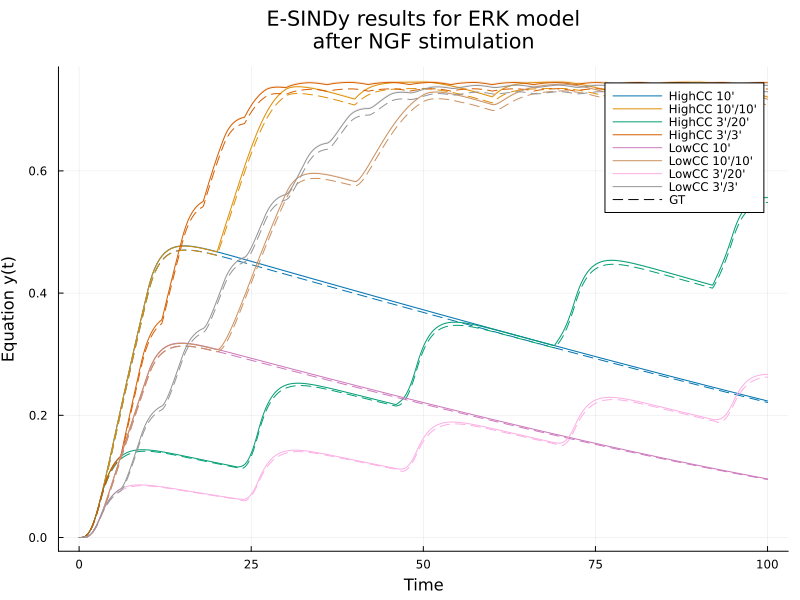

In [23]:
begin
	ngf_plot = plot_esindy(ngf_res, sample_idxs=1:8, iqr=true)[1]
	plot(ngf_plot, title="E-SINDy results for ERK model\nafter NGF stimulation\n", size=(800, 600), legend_position=:topright)
	#savefig("../Plots/ngf_esindy_100bt.svg")
end

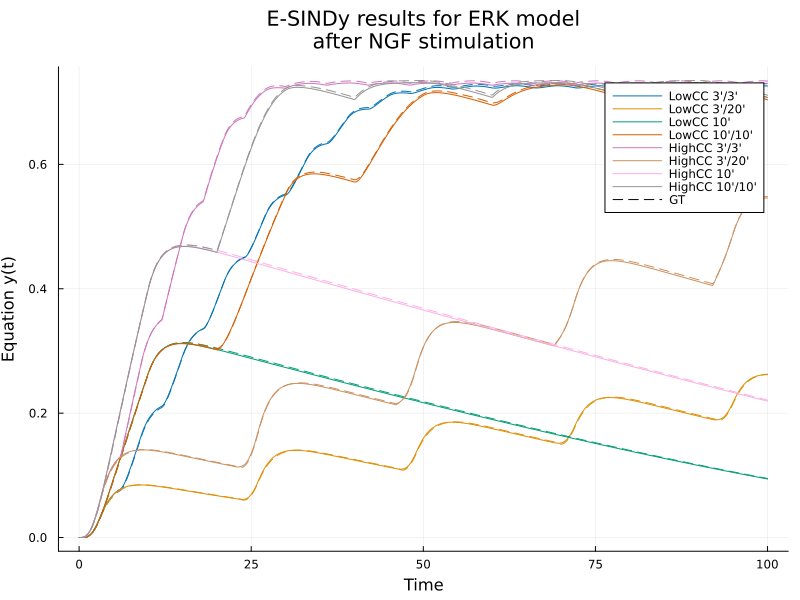

In [25]:
begin
	ngf_plot_lib = plot_esindy(ngf_res_lib.esindy, sample_idxs=1:8, iqr=true)[1]
	plot(ngf_plot_lib, title="E-SINDy results for ERK model\nafter NGF stimulation\n", size=(800, 600), legend_position=:topright)
	#savefig("../Plots/ngf_esindy_100bt_lib.svg")
end


#### EGF case




##### Run E-SINDy



In [26]:
#egf_res = esindy(egf_data, erk_basis, 100, coef_threshold=80, data_fraction=0.5)


##### Run Library E-SINDy
This section provides an alternative to b(r)agging E-SINDy in case of a large library. It first attempts at finding the most relevant terms of the library. Eventually, it speeds up the computations if the best set of hyperparameters have already been explored (smaller run of E-SINDy to identify them) and are specified.



In [27]:
begin 
	# Run first library E-SINDy to reduce the library size
	#egf_lib_res = library_bootstrap(egf_data, erk_basis, 5000, 10, implicit_id=22, )
	#egf_lib_basis = ESINDyModule.build_basis(egf_lib_res, erk_basis)
	
    # Run E-SINDy with resulting library
	#egf_res_lib = esindy(egf_data, egf_lib_basis, 100, coef_threshold=80)
end


##### Save or load the results (JLD2 file)



In [28]:
begin
	#jldsave("../Data/egf_esindy_100bt.jld2"; results=egf_res_up)
	egf_res = load("../Data/egf_esindy_100bt.jld2")["results"]
end

(data = (time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 … 0.0 0.0; 0.05721640887108781 0.011247181975800958 … 7.538255869705734e-10 1.632768715271874e-11; … ; 0.31020414100724075 0.1301796123043652 … 0.9483305989520017 0.14385883826155937; 0.291409822201035 0.12692671720975285 … 0.9482909443617127 0.14386100670421037], Y = [0.004808318342068643, 0.0052295378587452895, 0.005650703940586034, 0.006071712559559099, 0.006492387495765686, 0.006912463675285948, 0.007331574121209938, 0.007749249954328319, 0.008164935022309364, 0.008578008398697146  …  0.005411016189522083, 0.00564867945080566, 0.005882316253051689, 0.006112296615348144, 0.006339188177762445, 0.006563655825293335, 0.006786378371002134, 0.0070079813203221646, 0.007228983810828479, 0.0074497579521753225], GT = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], labels = Any["HighCC 10'", "HighCC 10'/10'", 

In [29]:
begin
	#jldsave("../Data/egf_esindy_100bt_lib.jld2"; results=egf_res_lib)
	egf_res_lib = load("../Data/egf_esindy_100bt_lib.jld2")["results"]
end

(esindy = (data = (time = [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125  …  98.875, 99.0, 99.125, 99.25, 99.375, 99.5, 99.625, 99.75, 99.875, 100.0], X = [0.0 0.0 … 0.0 0.0; 0.05721640887108718 0.008616739643084693 … -3.2296037182236847e-10 -5.647504465651846e-12; … ; 0.0035861655071965483 0.0018671537159216701 … 0.8480814086944358 0.12325160661939707; 0.0050893055250501 0.0014594030322373503 … 0.8475250782849179 0.12311077654341358], Y = [0.03076061733651908, 0.030859112526934837, 0.030957119611801392, 0.03105384650816405, 0.031148133561542682, 0.031238398242499882, 0.031322556417008277, 0.031398000545300744, 0.0314616661860037, 0.031510151848990274  …  -0.006668554101792284, -0.006924298882264214, -0.007180798939149468, -0.0074378979910634906, -0.007695455095902619, -0.007953345884574182, -0.008211463814173255, -0.00846972142365239, -0.008728051572363489, -0.008986408639501071], GT = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], labels = Any["LowCC 

##### Plot the results

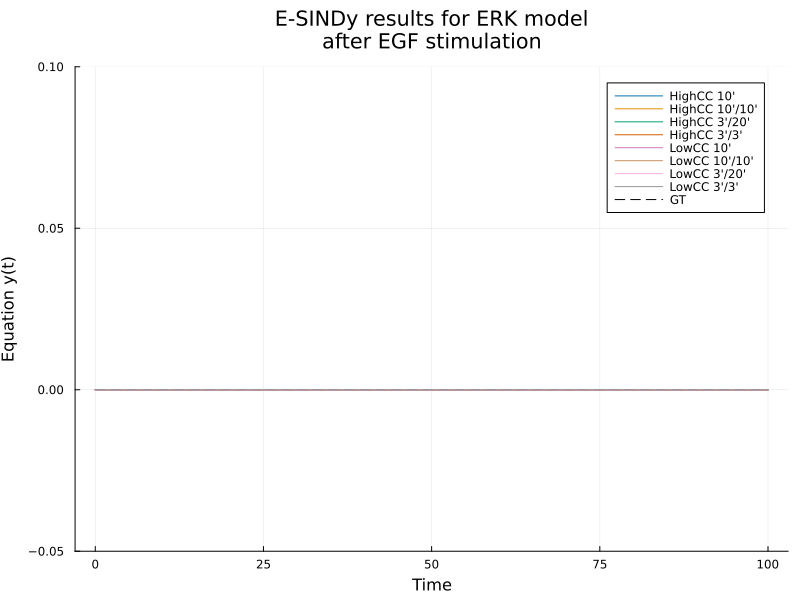

In [32]:
begin
	egf_plot = plot_esindy(egf_res, iqr=true)[1]
	plot(egf_plot, title="E-SINDy results for ERK model\nafter EGF stimulation\n", size=(800, 600), legend_position=:topright, ylim=(-0.05, .1))
	#savefig("../Plots/egf_esindy_100bt.svg")
end

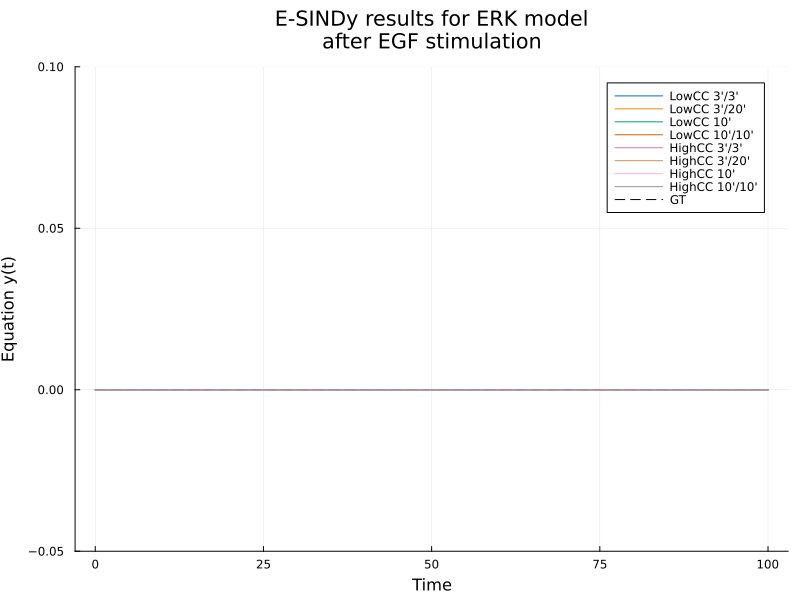

In [33]:
begin
	egf_lib_plot = plot_esindy(egf_res_lib.esindy, iqr=true)[1]
	plot(egf_lib_plot, title="E-SINDy results for ERK model\nafter EGF stimulation\n", size=(800, 600), legend_position=:topright, ylim=(-0.05, .1))
	#savefig("../Plots/egf_esindy_100bt_lib.svg")
end